# Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers
import splitfolders
import os

# Reading Dataset without augmentation

In [4]:
splitfolders.ratio("dataset", output="weather", ratio=(.8, .1, .1))

Copying files: 6862 files [00:03, 2213.05 files/s]


## loading conv base model

In [4]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### reading data and extracting features at the same time:

In [74]:
train_dir = "./weather/train/"
test_dir = "./weather/test/"
valid_dir = "./weather/val/"

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 50

def extract_features(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    features_count = len(next(os.walk(directory))[1])
    labels = np.zeros(shape=(sample_count, features_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size= (150, 150), 
                                            batch_size=batch_size, class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features (valid_dir, 500)
test_features, test_labels = extract_features(test_dir, 500)

Found 5484 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


In [78]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

## Building Model

### Model Structure

In [72]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4*4*512))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [73]:
history = model.fit(train_features, train_labels,
                    epochs = 30, batch_size=batch_size,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
40/40 [==============================] - 2s 27ms/step - loss: 2.4179 - accuracy: 0.2505 - val_loss: 2.5363 - val_accuracy: 0.1640
Epoch 2/30
40/40 [==============================] - 1s 22ms/step - loss: 1.7749 - accuracy: 0.4020 - val_loss: 2.3551 - val_accuracy: 0.1880
Epoch 3/30
40/40 [==============================] - 1s 22ms/step - loss: 1.5342 - accuracy: 0.4815 - val_loss: 2.1305 - val_accuracy: 0.2600
Epoch 4/30
40/40 [==============================] - 1s 22ms/step - loss: 1.3545 - accuracy: 0.5405 - val_loss: 1.9354 - val_accuracy: 0.3460
Epoch 5/30
40/40 [==============================] - 1s 22ms/step - loss: 1.2325 - accuracy: 0.5805 - val_loss: 1.7312 - val_accuracy: 0.3920
Epoch 6/30
40/40 [==============================] - 1s 21ms/step - loss: 1.1141 - accuracy: 0.6195 - val_loss: 1.5685 - val_accuracy: 0.4640
Epoch 7/30
40/40 [==============================] - 1s 22ms/step - loss: 1.0356 - accuracy: 0.6515 - val_loss: 1.4889 - val_accuracy: 0.5080
Epoch 8/30
40

In [76]:
model.save('q3_1.h5')
history_dic = history.history

In [79]:
# loading model
model = models.load_model('q3_1.h5')
mse, mae = model.evaluate(test_features, test_labels)
print(f"MSE = {mse}, MAE: {mae}")

16/16 [==============================] - 0s 12ms/step - loss: 0.8461 - accuracy: 0.7600
MSE = 0.8460596203804016, MAE: 0.7600000500679016


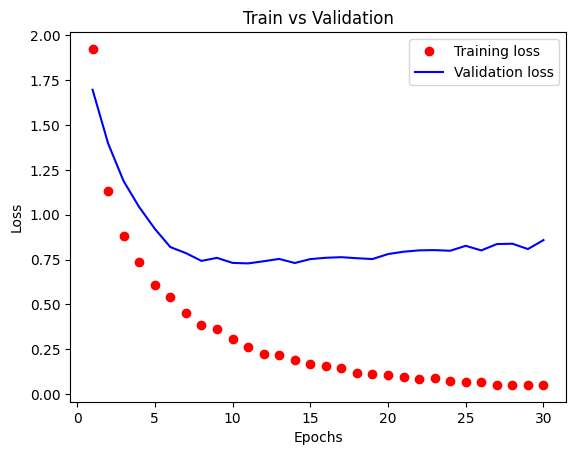

In [61]:
epochs = 30
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'ro', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

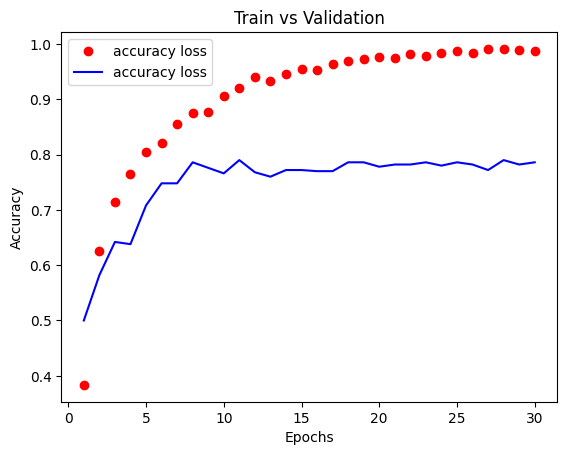

In [62]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'ro', label = "accuracy loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "accuracy loss")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Reading Data with augmentation

In [80]:
train_dir = "./weather/train/"
test_dir = "./weather/test/"
valid_dir = "./weather/val/"

datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range= .3,
                             rotation_range= .3,
                             horizontal_flip=True,
                             brightness_range=[.2, .8],
                             height_shift_range=.3,
                             zoom_range=.2,
                             fill_mode='nearest')
batch_size = 50

def extract_features(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    features_count = len(next(os.walk(directory))[1])
    labels = np.zeros(shape=(sample_count, features_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size= (150, 150), 
                                            batch_size=batch_size, class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features (valid_dir, 500)
test_features, test_labels = extract_features(test_dir, 500)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

Found 5484 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


In [64]:
model = models.Sequential()
# model.add(conv_base)
model.add(layers.Dense(512, activation='relu', input_dim=4*4*512))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='sigmoid'))

# conv_base.trainable = False
model.compile(optimizer=optimizers.RMSprop(learning_rate=.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
history = model.fit(train_features, train_labels,
                    epochs = 30, batch_size=batch_size,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
40/40 [==============================] - 1s 26ms/step - loss: 2.3714 - accuracy: 0.2625 - val_loss: 2.0753 - val_accuracy: 0.3180
Epoch 2/30
40/40 [==============================] - 1s 21ms/step - loss: 1.7808 - accuracy: 0.4255 - val_loss: 1.9500 - val_accuracy: 0.3680
Epoch 3/30
40/40 [==============================] - 1s 21ms/step - loss: 1.5475 - accuracy: 0.4895 - val_loss: 1.8150 - val_accuracy: 0.4300
Epoch 4/30
40/40 [==============================] - 1s 21ms/step - loss: 1.2981 - accuracy: 0.5620 - val_loss: 1.7116 - val_accuracy: 0.4280
Epoch 5/30
40/40 [==============================] - 1s 21ms/step - loss: 1.2037 - accuracy: 0.5900 - val_loss: 1.6362 - val_accuracy: 0.4580
Epoch 6/30
40/40 [==============================] - 1s 21ms/step - loss: 1.0943 - accuracy: 0.6250 - val_loss: 1.5324 - val_accuracy: 0.4720
Epoch 7/30
40/40 [==============================] - 1s 23ms/step - loss: 1.0191 - accuracy: 0.6480 - val_loss: 1.5715 - val_accuracy: 0.4480
Epoch 8/30
40

In [68]:
model.save('q3_1_2.h5')
history_dic = history.history

In [81]:
model = models.load_model('q3_1_2.h5')
mse, mae = model.evaluate(test_features, test_labels)
print(f"MSE = {mse}, MAE: {mae}")

16/16 [==============================] - 0s 10ms/step - loss: 1.6357 - accuracy: 0.5540
MSE = 1.6357144117355347, MAE: 0.5540000200271606


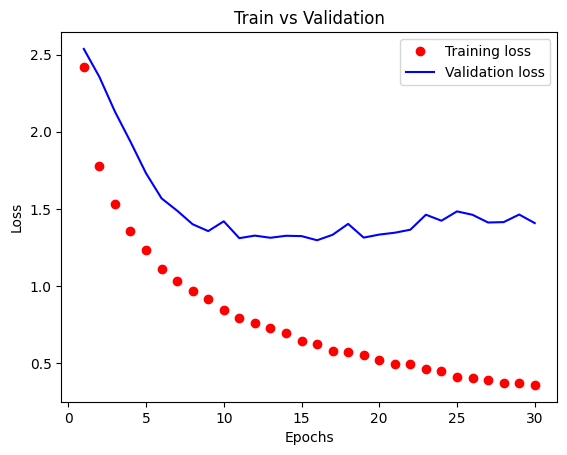

In [82]:
epochs = 30
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'ro', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

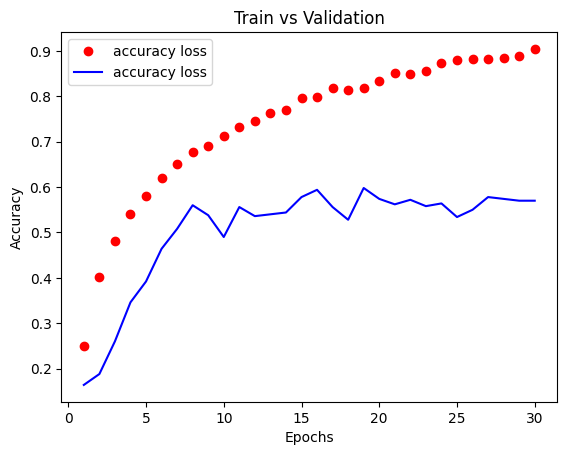

In [83]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'ro', label = "accuracy loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "accuracy loss")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Part 2

In [84]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [86]:
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [95]:
def create_conv_model():
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(11, activation='sigmoid'))

    model.compile(optimizer=optimizers.RMSprop(learning_rate=.00005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [89]:
# loading data again because we have reshaped our data
train_dir = "./weather/train/"
test_dir = "./weather/test/"
valid_dir = "./weather/val/"

batch_size = 50
train_datagen = ImageDataGenerator (rescale=1./255)
test_datagen = ImageDataGenerator (rescale=1./255)
valid_datagen = ImageDataGenerator (rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (150, 150),
    color_mode='rgb',
    batch_size=batch_size, class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size= (150, 150),
    color_mode='rgb',
    batch_size=batch_size, class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(
    valid_dir,
    target_size= (150, 150),
    color_mode='rgb',
    batch_size=batch_size, class_mode='categorical')


Found 5484 images belonging to 11 classes.
Found 696 images belonging to 11 classes.
Found 682 images belonging to 11 classes.


In [98]:
model = create_conv_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               4194816   
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 11)                5643      
                                                     

In [100]:
history = model.fit(train_generator,
                    epochs = 5, batch_size=batch_size,
                    validation_data = valid_generator)

model.save('q3_2_1.h5')
mse, mae = model.evaluate(test_generator)
print(f"MSE = {mse}, MAE: {mae}")

Epoch 1/5
110/110 [==============================] - 104s 946ms/step - loss: 0.0344 - accuracy: 0.9900 - val_loss: 0.7103 - val_accuracy: 0.8592
Epoch 2/5
110/110 [==============================] - 108s 978ms/step - loss: 0.0331 - accuracy: 0.9914 - val_loss: 0.8434 - val_accuracy: 0.8416
Epoch 3/5
110/110 [==============================] - 104s 943ms/step - loss: 0.0197 - accuracy: 0.9947 - val_loss: 0.8967 - val_accuracy: 0.8402
Epoch 4/5
110/110 [==============================] - 107s 973ms/step - loss: 0.0312 - accuracy: 0.9927 - val_loss: 0.8928 - val_accuracy: 0.8343
Epoch 5/5
14/14 [==============================] - 9s 667ms/step - loss: 0.8927 - accuracy: 0.8233
MSE = 0.89272141456604, MAE: 0.8232758641242981


In [101]:
history_dic = history.history

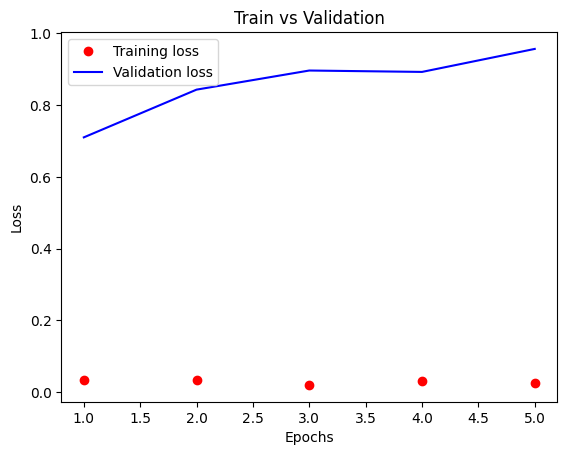

In [103]:
epochs = 5
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'ro', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

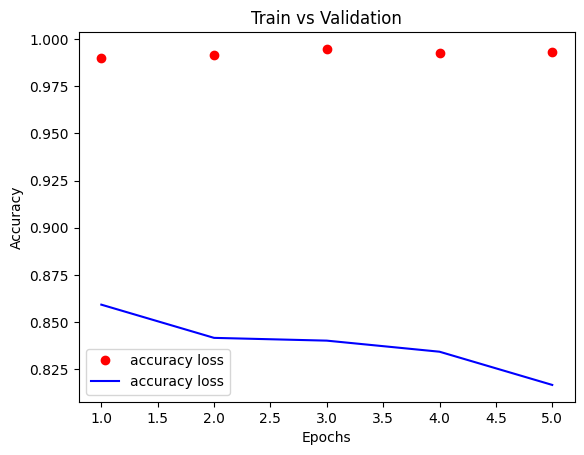

In [104]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'ro', label = "train acc")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "val acc")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### part 2 B

In [105]:
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [106]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=.00005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [107]:
history = model.fit(train_generator,
                    epochs = 5, batch_size=batch_size,
                    validation_data = valid_generator)

model.save('q3_2_2.h5')
mse, mae = model.evaluate(test_generator)
print(f"MSE = {mse}, MAE: {mae}")

Epoch 1/5
110/110 [==============================] - 117s 1s/step - loss: 0.3479 - accuracy: 0.9065 - val_loss: 1.1614 - val_accuracy: 0.7566
Epoch 2/5
110/110 [==============================] - 114s 1s/step - loss: 0.1574 - accuracy: 0.9455 - val_loss: 1.4545 - val_accuracy: 0.7082
Epoch 3/5
110/110 [==============================] - 128s 1s/step - loss: 0.1294 - accuracy: 0.9590 - val_loss: 0.7948 - val_accuracy: 0.8416
Epoch 4/5
110/110 [==============================] - 143s 1s/step - loss: 0.1153 - accuracy: 0.9639 - val_loss: 1.1611 - val_accuracy: 0.7830
Epoch 5/5
14/14 [==============================] - 9s 666ms/step - loss: 1.0235 - accuracy: 0.7773
MSE = 1.0235438346862793, MAE: 0.7772988677024841


In [111]:
history_dic = history.history

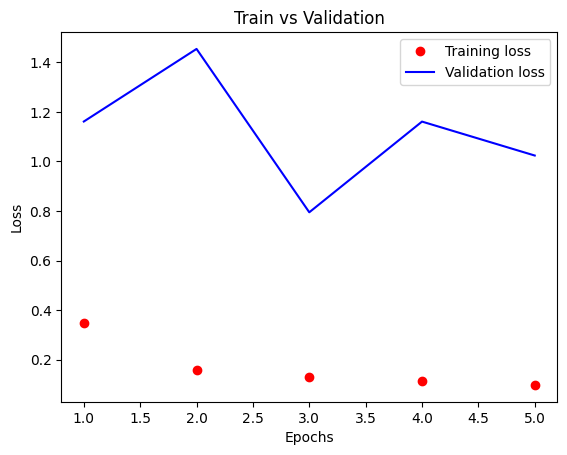

In [112]:
epochs = 5
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'ro', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

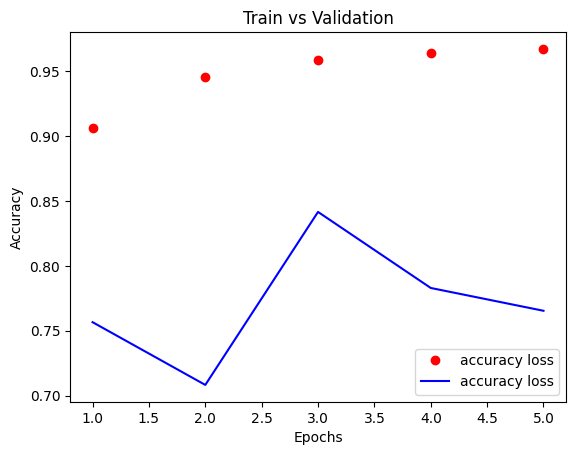

In [113]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'ro', label = "train acc")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "val acc")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()